In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# -------------------------------------------------------------------
# 1) Define the wave equation with a time-dependent left boundary
# -------------------------------------------------------------------

def rk4_step(state, f, t, dt, *args):
    """
    One RK4 step: state -> state at time t+dt.
    f: a function f(state, t, *args) -> (dstate/dt)
    """
    k1 = f(state, t, *args)
    s1 = tuple(s + 0.5*dt*k for s,k in zip(state, k1))

    k2 = f(s1, t + 0.5*dt, *args)
    s2 = tuple(s + 0.5*dt*k for s,k in zip(state, k2))

    k3 = f(s2, t + 0.5*dt, *args)
    s3 = tuple(s + dt*k for s,k in zip(state, k3))

    k4 = f(s3, t + dt, *args)

    new_state = tuple(
        s + (dt/6.0)*(k1_i + 2*k2_i + 2*k3_i + k4_i)
        for (s, k1_i, k2_i, k3_i, k4_i) in zip(state, k1, k2, k3, k4)
    )
    return new_state


def wave_equation_forced(state, t, c, dx):
    """
    Given (u, v) at time t, returns (du_dt, dv_dt) for the 1D wave eqn:
        d^2 u / dt^2 = c^2 d^2 u / dx^2

    BUT the left boundary x=0 is forced to be:
        u(0,t) = left_bc_func(t)
    and the right boundary x=L is fixed at 0.

    state: (u, v), each of length N+1
    t: current time
    left_bc_func(t): a function that gives the displacement at x=0
    c: wave speed
    dx: spatial step
    """
    u, v = state
    N = len(u) - 1  # grid points are 0..N

    du_dt = np.zeros_like(u)
    dv_dt = np.zeros_like(u)

    # Interior updates (1..N-1)
    for i in range(1, N):
        du_dt[i] = v[i]
        dv_dt[i] = c**2 * (u[i+1] - 2.0*u[i] + u[i-1]) / (dx**2)

    # Boundary conditions
    # Left boundary: u(0) = left_bc_func(t)
    # We'll avoid PDE update at i=0 and just set derivatives to 0
    du_dt[0] = 0.0
    dv_dt[0] = 0.0

    # Right boundary: u(N) = 0 (fixed).
    du_dt[N] = 0.0
    dv_dt[N] = 0.0

    return (du_dt, dv_dt)

# -------------------------------------------------------------------
# 2) 4th-order Runge-Kutta single step
# -------------------------------------------------------------------

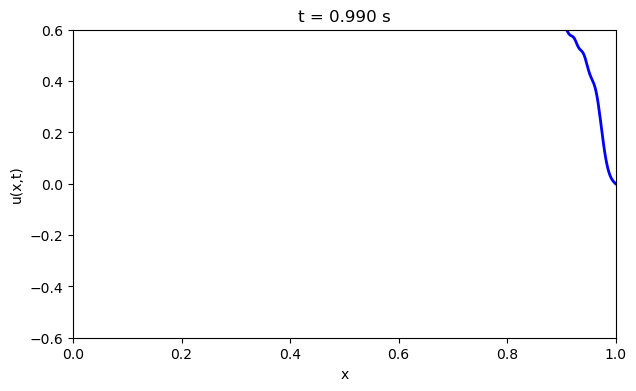

In [4]:
L = 1.0          # domain length
N = 500          # number of intervals => N+1 points
dx = L / N
x = np.linspace(0, L, N+1)

# --- Time setup ---
dt = 0.0005
num_steps = 2000

# --- Wave speed ---
c = 1.0

# --- Define the time-dependent displacement at x=0 ---
# Example: a sinusoidal input
freq = 5.0       # frequency
amp = 0.5        # amplitude
def left_bc_func(t):
    return amp * np.arctan(2.0 * np.pi * freq * t)

# --- Initial condition: u = 0, v = 0 ---
u0 = np.zeros(N+1)
v0 = np.zeros(N+1)
state = (u0, v0)

# We'll store snapshots for animation
store_interval = 20
snapshots = []
times = []

current_time = 0.0

for step in range(num_steps):
    # Enforce boundary at this time
    u, v = state
    u[0] = left_bc_func(current_time)  # left boundary
    state = (u, v)

    # RK4 step
    state = rk4_step(state, wave_equation_forced, current_time, dt, c, dx)

    current_time += dt

    # Store for animation
    if step % store_interval == 0:
        u, v = state
        # again fix boundary for consistency in snapshot
        u[0] = left_bc_func(current_time)
        u[N] = 0.0
        snapshots.append(u.copy())
        times.append(current_time)

# --- Animation and GIF output ---
fig, ax = plt.subplots(figsize=(7,4))
line, = ax.plot([], [], 'b-', lw=2)
ax.set_xlim(0, L)
ax.set_ylim(-1.2*amp, 1.2*amp)
ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
ax.set_title("Wave Eq with Time-Dependent Left BC")

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    line.set_data(x, snapshots[i])
    ax.set_title(f"t = {times[i]:.3f} s")
    return (line,)

ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(snapshots), interval=50, blit=True
)

# Save to GIF with Pillow writer
ani.save("wave_forced_left.gif", writer='pillow', fps=20)

plt.show()
